<a href="https://colab.research.google.com/github/Sowndharyaramanadhan/Predictive-Maintainance/blob/main/Predictive_Maintainance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Maintainance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/predictivemaintanace.zip .
!unzip predictivemaintanace.zip

Archive:  predictivemaintanace.zip
  inflating: CMaps/Damage Propagation Modeling.pdf  
  inflating: CMaps/RUL_FD001.txt     
  inflating: CMaps/RUL_FD002.txt     
  inflating: CMaps/RUL_FD003.txt     
  inflating: CMaps/RUL_FD004.txt     
  inflating: CMaps/readme.txt        
  inflating: CMaps/test_FD001.txt    
  inflating: CMaps/test_FD002.txt    
  inflating: CMaps/test_FD003.txt    
  inflating: CMaps/test_FD004.txt    
  inflating: CMaps/train_FD001.txt   
  inflating: CMaps/train_FD002.txt   
  inflating: CMaps/train_FD003.txt   
  inflating: CMaps/train_FD004.txt   
  inflating: CMaps/x.txt             


In [ ]:
import pathlib

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset Organization

Data Set: FD001  
Train trjectories: 100  
Test trajectories: 100  
Conditions: ONE (Sea Level)  
Fault Modes: ONE (HPC Degradation)  

Data Set: FD002  
Train trjectories: 260  
Test trajectories: 259  
Conditions: SIX  
Fault Modes: ONE (HPC Degradation)  

Data Set: FD003  
Train trjectories: 100  
Test trajectories: 100  
Conditions: ONE (Sea Level)  
Fault Modes: TWO (HPC Degradation, Fan Degradation)  

Data Set: FD004  
Train trjectories: 248  
Test trajectories: 249  
Conditions: SIX  
Fault Modes: TWO (HPC Degradation, Fan Degradation)

In [ ]:
DATA_DIR = pathlib.Path('CMaps')

In [ ]:
def load_dataset(file):
    df = pd.read_csv(
      DATA_DIR / f'{file}.txt',
      header=None,
      sep=' ',
      names=[
          'unit',
          'time',
          'o0', 'o1', 'o2',
          *[f's{i}' for i in range(23)],
      ],
      dtype = {
          'unit': 'int32',
          'time': 'int32',
        }
    ).drop(['s21', 's22'], axis=1)


    df.set_index(['unit', 'time'], inplace=True)
    return df

def load_train(dataset):
  return load_dataset(f'train_{dataset}')

def load_test(dataset):

  test_df = load_dataset(f'test_{dataset}')

  rul = pd.read_csv(
      DATA_DIR / f"RUL_{dataset}.txt",
      header=None,
      names=['rul'],
      dtype = {
          'rul': 'int32',
      }
    )

  print(len(rul), len(test_df.groupby('unit')))
  rul['unit'] = test_df.index.get_level_values('unit').unique()
  rul.set_index('unit', inplace=True)
  return test_df, rul

In [ ]:
df = load_train('FD001')
df.head()

o0      o1     o2      s0      s1       s2       s3     s4  \
unit time                                                                   
1    1    -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
     2     0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
     3    -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
     4     0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
     5    -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

              s5      s6  ...     s11      s12      s13     s14   s15  s16  \
unit time                 ...                                                
1    1     21.61  554.36  ...  521.66  2388.02  8138.62  8.4195  0.03  392   
     2     21.61  553.75  ...  522.28  2388.07  8131.49  8.4318  0.03  392   
     3     21.61  554.26  ...  522.42  2388.03  8133.23  8.4178  0.03  390   
     4     21.61  554.45  ...  522.86  2388.08  8133.83  8.3682  0.03  392   
     5     21.61  554.00  ...  522.19  2388.04  8133.80  8.4294  0.03  393   

            s17    s18    s19      s20  
unit time                               
1    1     2388  100.0  39.06  23.4190  
     2     2388  100.0  39.00  23.4236  
     3     2388  100.0  38.95  23.3442  
     4     2388  100.0  38.88  23.3739  
     5     2388  100.0  38.90  23.4044  

[5 rows x 24 columns]

In [ ]:
units = np.array([df.index.get_level_values('unit').unique()])
print("No. of units in FD001", len(units[0]))

No. of units in FD001 100


In [ ]:
def plot_hist(df):
  fig, axes = plt.subplots(6, 4, figsize=(18, 18))

  fig.suptitle(f'Distribution')
  axes = axes.flatten()
  fig.tight_layout()
  items = df.columns

  for i, item in enumerate(items):
    ax = axes[i]
    sns.histplot(ax=ax, data=df.loc[:, item], kde=True)

  plt.show()



def plot_sensors_trajectories(df, fro=0, to=-1):

  assert fro < to or to == -1, "fro must be less than to"
  fig, axes = plt.subplots(6, 4, figsize=(18, 14))

  trajectories = [df.loc[unit] for unit in units[0]]

  items = trajectories[0].columns
  fig.suptitle(f'Trajectories')
  axes = axes.flatten()
  fig.tight_layout()
  for i, item in enumerate(items):
    ax = axes[i]
    ax.set_title(item)
    for trajectory in trajectories:
      sns.lineplot(ax=ax, x=trajectory.index.values, y=trajectory[item])


  plt.show()

def plot_sensors_trajectory_and_rul(df, unit, rul, fro=0, to=-1, scale_rul=True, scale_df=True):
  assert fro < to or to == -1, "fro must be less than to"
  items = df.columns
  fig, axes = plt.subplots(np.ceil(len(items)/4).astype(int), 4, figsize=(18, 14))
  fig.suptitle(f'RUL {unit}')
  axes = axes.flatten()
  fig.tight_layout()

  rul = rul.loc[unit]
  if scale_rul:
    rul = (rul - rul.min()) / (rul.max() - rul.min())
  for i, item in enumerate(items):
    ax = axes[i]
    ax.set_title(item)
    vals = df.loc[unit][item]
    if scale_df:
      vals = (vals - vals.min()) / (vals.max() - vals.min())
    sns.lineplot(ax=ax, x=df.loc[unit].index.values, y=vals)
    sns.lineplot(ax=ax, x=rul.index.values, y=rul['rul'])
    ax.legend(['Sensor', 'RUL'])

  plt.show()

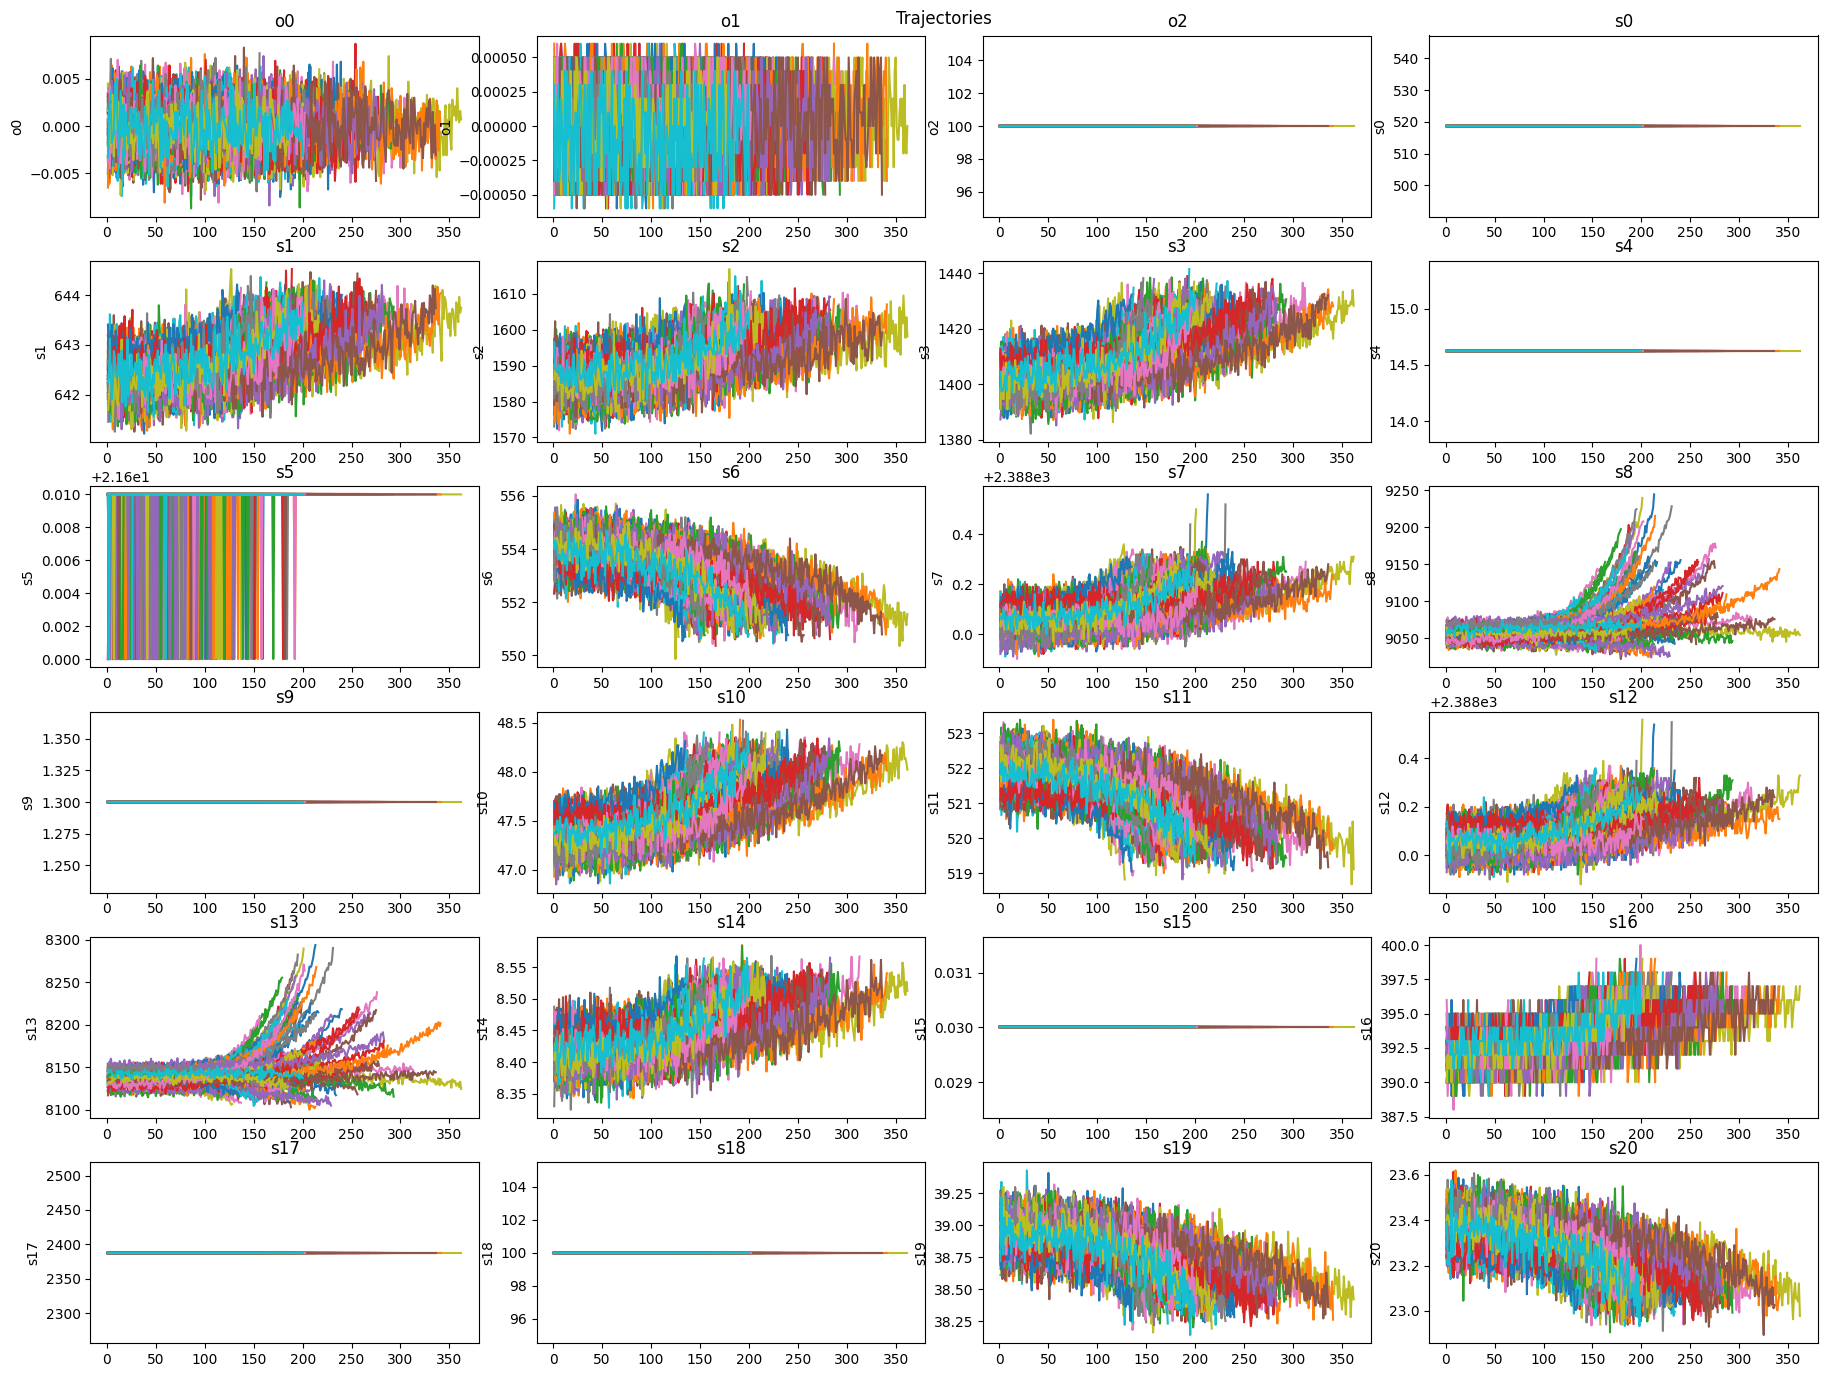

In [ ]:
plot_sensors_trajectories(df)

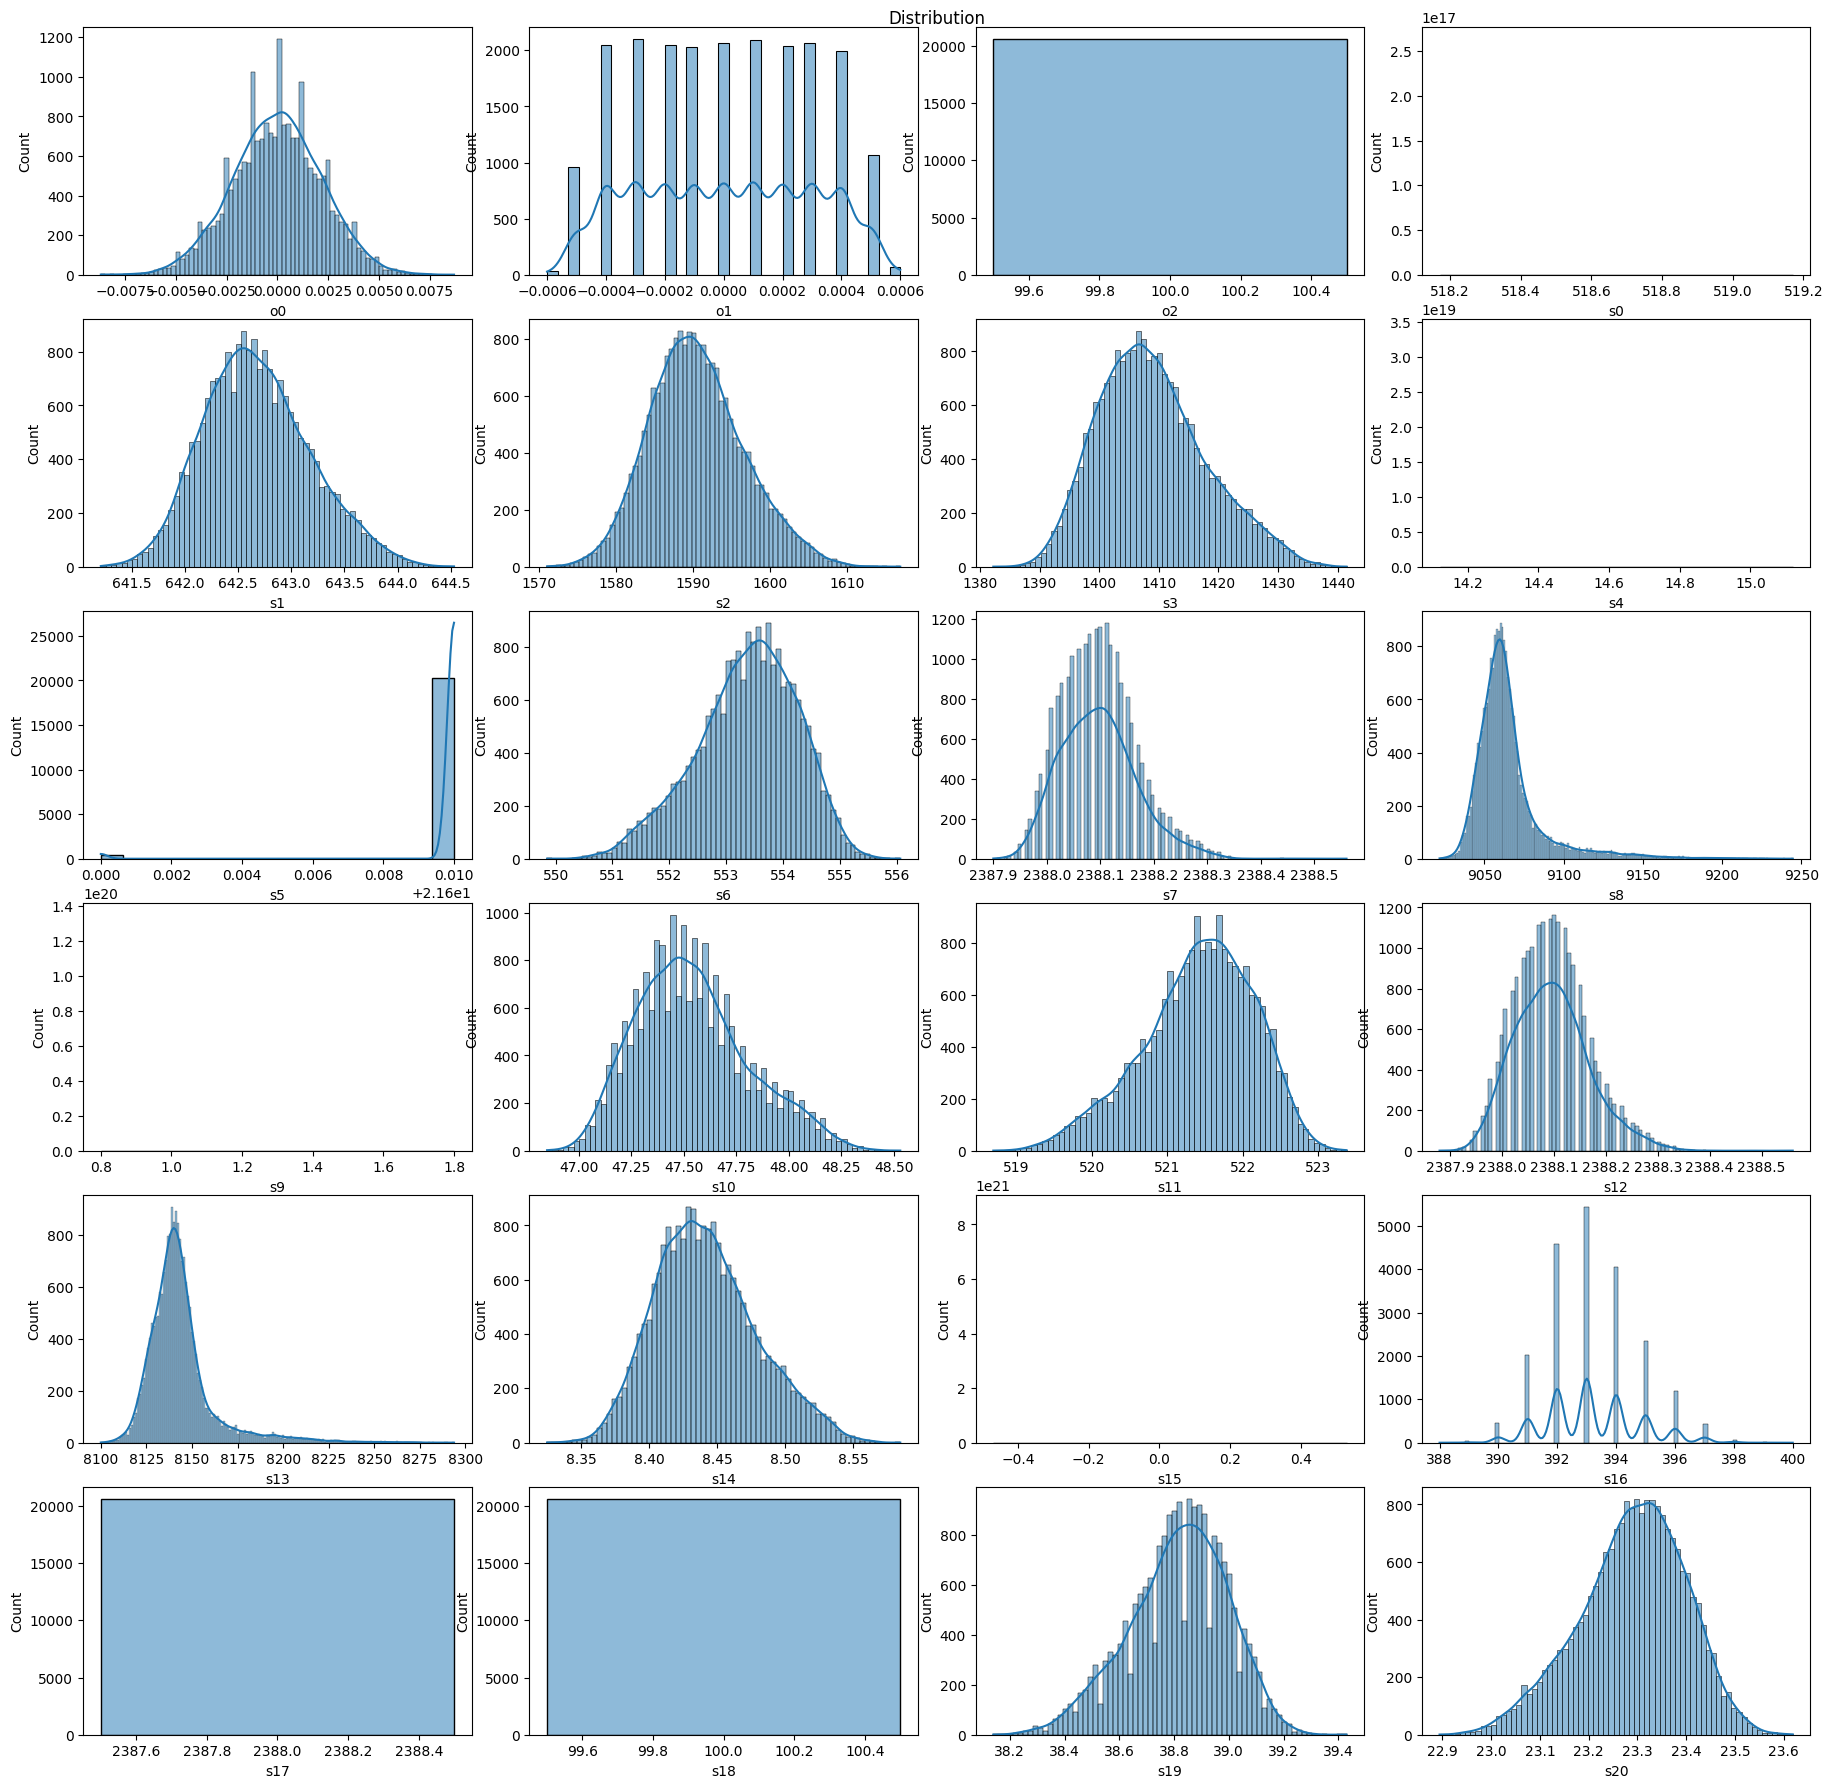

In [ ]:
plot_hist(df)

From the above graph, it is observed that sensor values such as o2, s0, s4, s15 etc., have zero or infinitely small standard deviation. Thus, these features are not suitable for prediction of RUL and has to be removed.

In [ ]:
def get_rul_on_train(train_df):
  rul = pd.DataFrame(index=train_df.index)
  for trajectory in train_df.index.get_level_values('unit').unique():
    rul.loc[trajectory, 'rul'] = train_df.loc[trajectory].index.max() - rul.loc[trajectory].index
  return rul

In [ ]:
rul = get_rul_on_train(df)

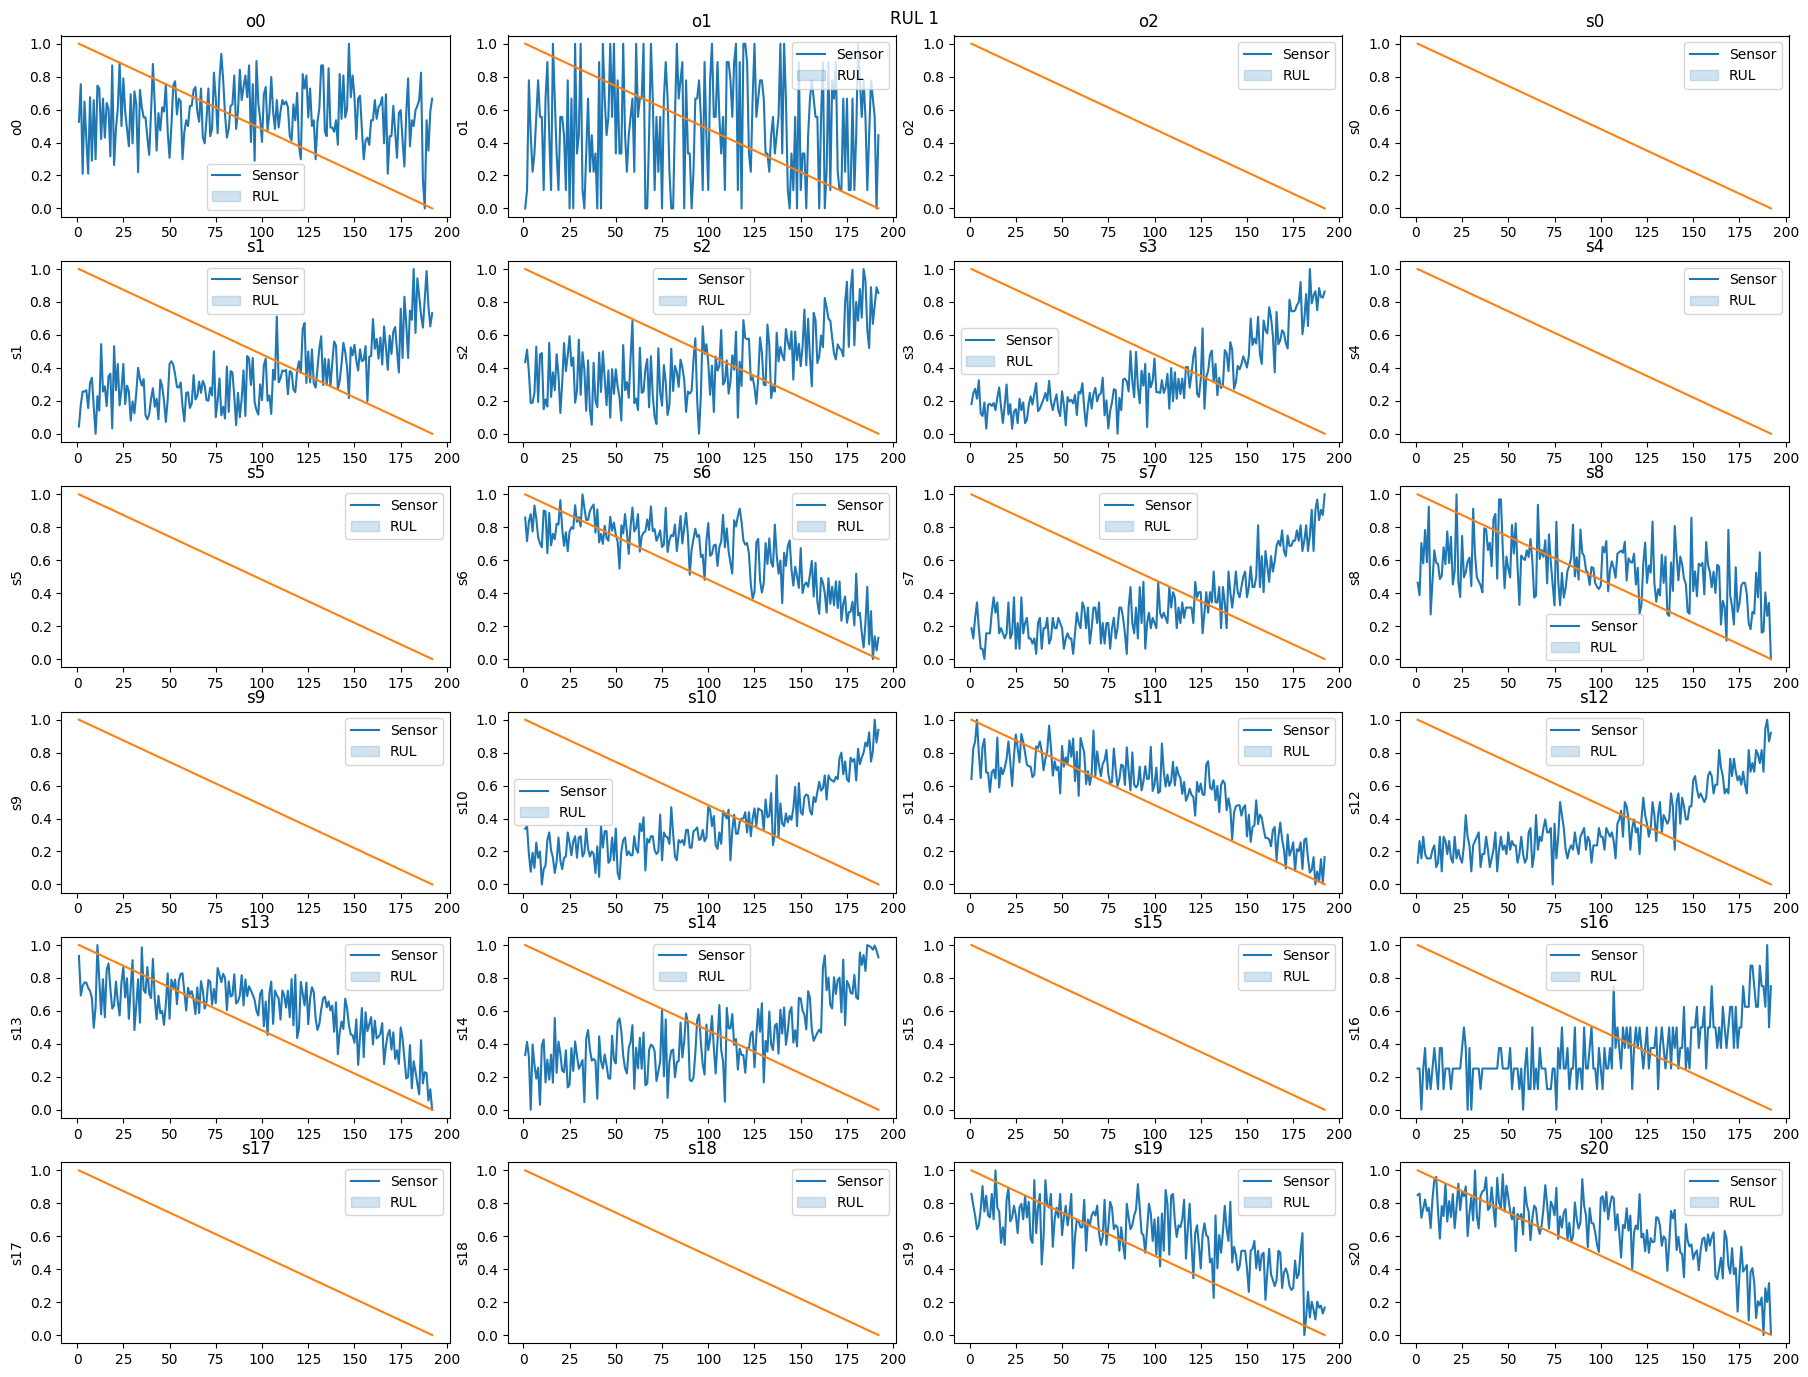

In [ ]:
plot_sensors_trajectory_and_rul(df, unit=1, rul=rul)

The features s6, s8, s11, s13, s19, s20 directly correlates with the RUL

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(df, std_thres=1e-4):
  df_copy = df.copy()
  # Remove sensor values with less std
  df_copy = df_copy.loc[:, df_copy.std() > std_thres]


  # df_copy = df_copy[['s20', 's19', 's11', 's12', 's7', 's6']]

  rul = get_rul_on_train(df_copy)
  ma = pd.concat([
    df_copy.loc[units].rolling(window=10, min_periods=5, center=True).mean()
    for units in df_copy.index.get_level_values('unit').unique()
  ], axis=0)

  std = pd.concat([
    df_copy.loc[units].rolling(window=10, min_periods=5, center=True).std()
    for units in df_copy.index.get_level_values('unit').unique()
  ], axis=0)

  ma = ma.set_index(df_copy.index)
  std = std.set_index(df_copy.index)
  normalized = (df_copy - ma) / std
  normalized.columns = [f'n_{col}' for col in normalized.columns]
  df_copy = pd.concat([df_copy, normalized], axis=1)

  df_copy = df_copy.dropna(axis=1)


  scaler = MinMaxScaler()
  # df_copy = pd.DataFrame(scaler.fit_transform(df_copy), index=df_copy.index, columns=df_copy.columns)
  # rul = pd.DataFrame(scaler.fit_transform(rul), index=rul.index, columns=rul.columns)

  return df_copy, rul, scaler

In [ ]:
processed_df, processed_rul, cols = preprocess(df)
processed_df.head()

o0      o1      s1       s2       s3     s5      s6       s7  \
unit time                                                                     
1    1    -0.0007 -0.0004  641.82  1589.70  1400.60  21.61  554.36  2388.06   
     2     0.0019 -0.0003  642.15  1591.82  1403.14  21.61  553.75  2388.04   
     3    -0.0043  0.0003  642.35  1587.99  1404.20  21.61  554.26  2388.08   
     4     0.0007  0.0000  642.35  1582.79  1401.87  21.61  554.45  2388.11   
     5    -0.0019 -0.0002  642.37  1582.85  1406.22  21.61  554.00  2388.06   

                s8    s10  ...      n_s6      n_s7      n_s8     n_s10  \
unit time                  ...                                           
1    1     9046.19  47.47  ...  0.684754 -0.377964 -0.735934  0.940006   
     2     9044.07  47.49  ... -1.514861 -0.693296 -1.344031  1.253914   
     3     9052.94  47.27  ... -0.004726  0.745260  0.382922 -0.275176   
     4     9049.48  47.13  ...  0.760906  1.699937 -0.033307 -1.287710   
     5     9055.15  47.28  ... -0.444846  0.329645  1.019102 -0.152902   

              n_s11     n_s12     n_s13     n_s14     n_s19     n_s20  
unit time                                                              
1    1    -1.437905 -1.081734  1.669353  0.237356  1.385481  0.775560  
     2     0.214532  1.029234 -1.018871  0.812680  0.576805  1.098433  
     3     0.518334 -0.561769 -0.218509  0.322622 -0.392419 -1.460579  
     4     1.555571  1.788084  0.183613 -2.063917 -1.346652 -0.093937  
     5     0.011000 -0.108505  0.372222  1.019194 -1.197898  0.637269  

[5 rows x 32 columns]

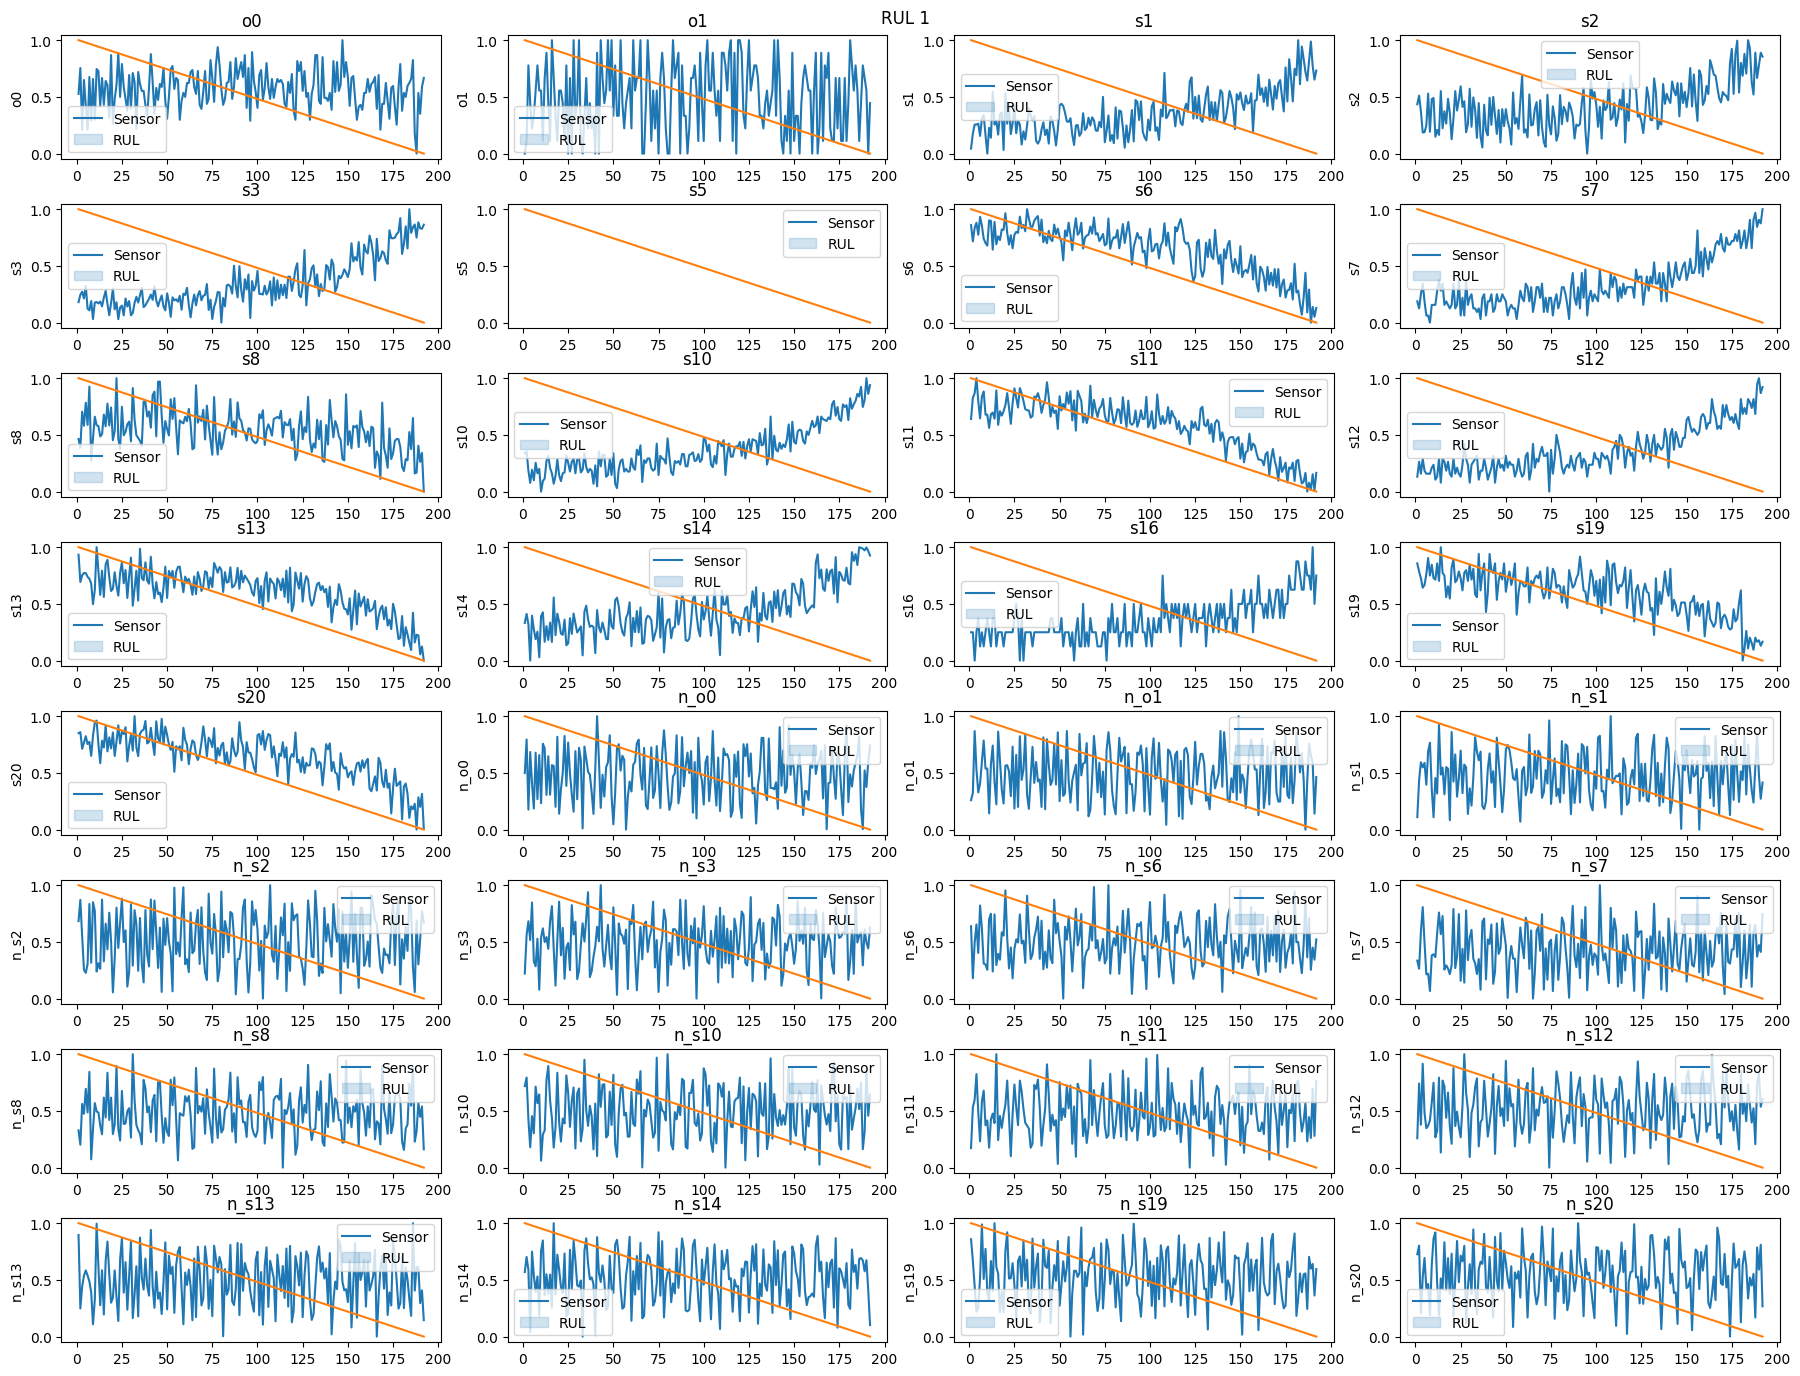

In [ ]:
plot_sensors_trajectory_and_rul(processed_df, unit=1, rul=processed_rul)

In [ ]:
processed_rul.head()

rul
unit time       
1    1     191.0
     2     190.0
     3     189.0
     4     188.0
     5     187.0

### Estimating Conditional parameter (lifeIndex)




In [ ]:
from sklearn.model_selection import train_test_split


def split_train_test(df, rul, test_size=0.2):
  train_units, test_units =  train_test_split(
      df.index.get_level_values('unit').unique(),
      test_size=0.2,
  )

  train_x = df.loc[train_units]
  test_x = df.loc[test_units]

  train_y = rul.loc[train_units]
  test_y = rul.loc[test_units]

  return train_x, test_x, train_y, test_y



In [ ]:
train_df, test_df, train_rul, test_rul = split_train_test(processed_df, processed_rul)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, losses, optimizers, metrics

In [ ]:
lifeIndex_model = Sequential([
    layers.Input((train_df.shape[1],)),
    layers.Dense(512, activation='linear'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='linear'),
    # layers.Dense(64, activation='linear'),
    layers.Dense(1, activation='linear')
])

lifeIndex_model.compile(
    loss=losses.MeanSquaredError(),
    optimizer=optimizers.Adam(0.0001),
    metrics=[metrics.MeanAbsoluteError()]
)

In [ ]:
lifeIndex_model.fit(
    train_df,
    train_rul,
    epochs=150,
    batch_size=64,
    validation_data=(test_df, test_rul),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    ]
)

Epoch 1/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 15030.0703 - mean_absolute_error: 87.8158 - val_loss: 4723.6079 - val_mean_absolute_error: 57.9913
Epoch 2/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5495.5942 - mean_absolute_error: 60.2473 - val_loss: 7579.0586 - val_mean_absolute_error: 72.3551
Epoch 3/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6063.5708 - mean_absolute_error: 63.2898 - val_loss: 4158.4414 - val_mean_absolute_error: 54.7481
Epoch 4/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5416.0410 - mean_absolute_error: 59.8483 - val_loss: 6223.5518 - val_mean_absolute_error: 63.3281
Epoch 5/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5365.2695 - mean_absolute_error: 59.3965 - val_loss: 5535.3979 - val_mean_absolute_error: 60.1147
Epoch 6/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5604.3438 - mean_absolute_error: 60.4174 - val_loss: 5472.6055 - val_mean_absolute_error: 61.9410
Epoch 7/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [ ]:
pred_rul = pd.DataFrame(lifeIndex_model.predict(test_df), index=test_rul.index, columns=test_rul.columns)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


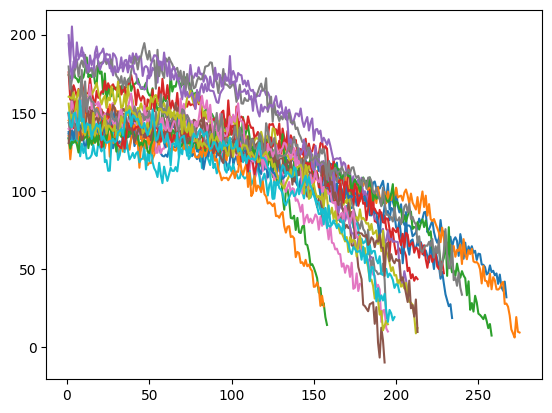

In [ ]:
sample_unit = pred_rul.index.get_level_values('unit').unique()
for unit in sample_unit:
  plt.plot(pred_rul.loc[unit].index, pred_rul.loc[unit, 'rul'])

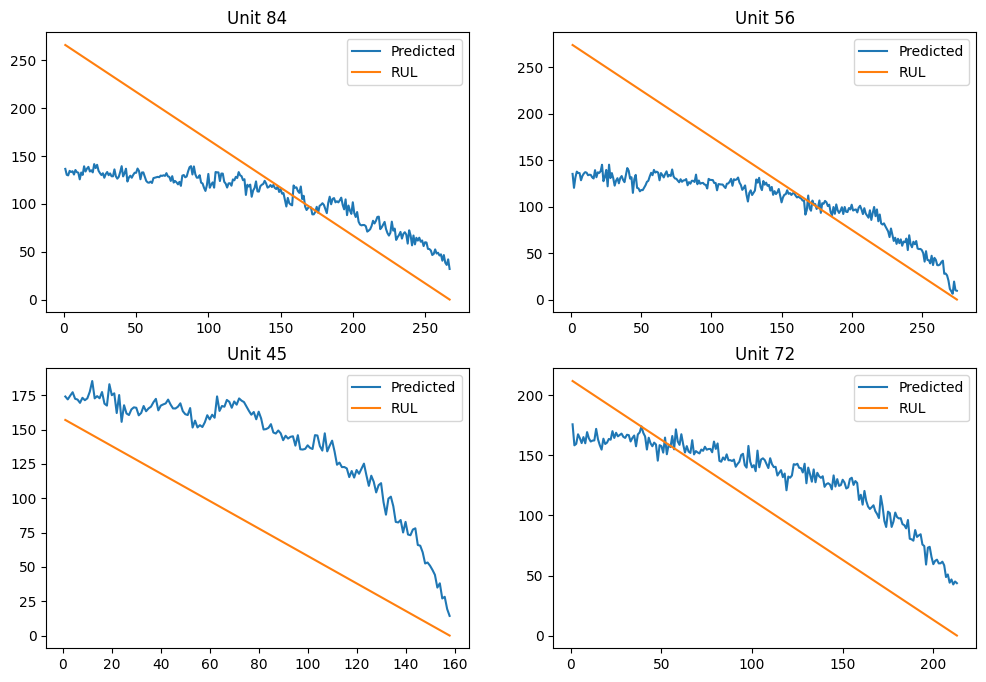

In [ ]:

plt.figure(figsize=(12, 8))
for i, units in enumerate(sample_unit[:4]):
  plt.subplot(2, 2, i+ 1)
  plt.title(f'Unit {units}')
  pred_unit = pred_rul.loc[units]
  rul_unit = test_rul.loc[units]
  plt.plot(pred_unit.index,pred_unit.values, label='Predicted')
  plt.plot(rul_unit.index, rul_unit.values, label='RUL')
  plt.legend()
plt.show()


In [ ]:
datasets_exp = [
    'FD001',
    'FD002',
    'FD003',
    'FD004'
]

In [ ]:
dfs = [load_train(dataset) for dataset in datasets_exp]
preprocessed_dfs = [preprocess(df) for df in dfs]

In [ ]:
# scalers = [preprocessed_df[2] for preprocessed_df in preprocessed_dfs]
datasets = [
    train_test_split(df, rul, test_size=0.2)
    for df, rul, _ in preprocessed_dfs
]

In [ ]:
class LifeIndexModel(tf.keras.Model):
  def __init__(self, df):
    super(LifeIndexModel, self).__init__()

    self.predictor = Sequential([
    layers.Input((df.shape[1],)),
    layers.Dense(128, activation='linear'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='linear'),
      layers.Dense(1, activation='linear')
    ])

  def call(self, inputs):
    return self.predictor(inputs)


In [ ]:
models = [LifeIndexModel(df[0]) for df in preprocessed_dfs]

In [ ]:
for model, dataset in zip(models, datasets):
  train_x, test_x, train_y, test_y = dataset
  model.compile(
      loss=losses.MeanSquaredError(),
      optimizer=optimizers.Adam(0.00019/3),
      metrics=[metrics.MeanAbsoluteError()]
  )
  model.fit(
      train_x,
      train_y,
      epochs=80,
      batch_size=64,
      validation_data=(test_x, test_y),
      callbacks=[
          tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
      ]
  )

Epoch 1/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 203599.6250 - mean_absolute_error: 260.6125 - val_loss: 4892.4712 - val_mean_absolute_error: 57.8146
Epoch 2/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4930.8125 - mean_absolute_error: 57.8228 - val_loss: 4914.6636 - val_mean_absolute_error: 58.1138
Epoch 3/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4878.1631 - mean_absolute_error: 57.7383 - val_loss: 4889.3877 - val_mean_absolute_error: 57.7453
Epoch 4/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4888.1729 - mean_absolute_error: 57.6540 - val_loss: 5006.1309 - val_mean_absolute_error: 57.8388
Epoch 5/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5000.4482 - mean_absolute_error: 58.2380 - val_loss: 4943.2061 - val_mean_absolute_error: 58.3732
Epoch 6/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4970.4731 - mean_absolute_error: 58.0927 - val_loss: 4915.4917 - val_mean_absolute_error: 58.1581
Epoch 7/80
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/st

In [ ]:
test_df, test_rul = load_test('FD002')
test_df


259 259


o0      o1     o2      s0      s1       s2       s3     s4  \
unit time                                                                    
1    1      9.9987  0.2502  100.0  489.05  605.03  1497.17  1304.99  10.52   
     2     20.0026  0.7000  100.0  491.19  607.82  1481.20  1246.11   9.35   
     3     35.0045  0.8400  100.0  449.44  556.00  1359.08  1128.36   5.48   
     4     42.0066  0.8410  100.0  445.00  550.17  1349.69  1127.89   3.91   
     5     24.9985  0.6213   60.0  462.54  536.72  1253.18  1050.69   7.05   
...            ...     ...    ...     ...     ...      ...      ...    ...   
259  119   35.0015  0.8403  100.0  449.44  555.56  1366.01  1129.47   5.48   
     120   42.0066  0.8405  100.0  445.00  549.42  1351.13  1123.86   3.91   
     121   42.0061  0.8400  100.0  445.00  549.65  1349.14  1118.91   3.91   
     122    0.0024  0.0003  100.0  518.67  642.58  1589.61  1408.16  14.62   
     123   42.0033  0.8400  100.0  445.00  549.77  1342.50  1126.96   3.91   

              s5      s6  ...     s11      s12      s13      s14   s15  s16  \
unit time                 ...                                                 
1    1     15.49  394.54  ...  371.69  2388.18  8114.10   8.6476  0.03  369   
     2     13.66  334.36  ...  315.32  2388.12  8053.06   9.2405  0.02  364   
     3      8.00  193.55  ...  183.04  2387.75  8053.04   9.3472  0.02  333   
     4      5.71  138.74  ...  130.40  2387.72  8066.90   9.3961  0.02  332   
     5      9.03  175.75  ...  164.56  2028.05  7865.66  10.8682  0.02  305   
...          ...     ...  ...     ...      ...      ...      ...   ...  ...   
259  119    8.00  194.87  ...  183.05  2388.39  8088.36   9.3215  0.02  334   
     120    5.72  138.34  ...  130.74  2388.31  8108.48   9.3542  0.02  332   
     121    5.72  138.27  ...  130.96  2388.34  8098.77   9.3836  0.02  331   
     122   21.61  553.13  ...  522.25  2388.00  8161.85   8.4279  0.03  393   
     123    5.71  138.37  ...  130.93  2388.40  8105.28   9.3458  0.02  331   

            s17     s18    s19      s20  
unit time                                
1    1     2319  100.00  28.42  17.1551  
     2     2324  100.00  24.29  14.8039  
     3     2223  100.00  14.98   8.9125  
     4     2212  100.00  10.35   6.4181  
     5     1915   84.93  14.31   8.5740  
...         ...     ...    ...      ...  
259  119   2223  100.00  14.94   8.9065  
     120   2212  100.00  10.57   6.4075  
     121   2212  100.00  10.57   6.4805  
     122   2388  100.00  39.08  23.3589  
     123   2212  100.00  10.63   6.3480  

[33991 rows x 24 columns]

In [ ]:
preprocessed_test_df, _, r_scaler = preprocess(test_df)

pred_rul = pd.DataFrame(
    models[1].predict(preprocessed_test_df.groupby('unit').last()
    ), index=test_rul.index, columns=test_rul.columns)

pd.concat([test_rul, pred_rul, test_rul < 10, pred_rul < 10], axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,rul,rul,rul,rul
unit,,,,
1,18,34.154068,False,False
2,79,63.675491,False,False
3,106,87.445694,False,False
4,110,78.034714,False,False
5,15,53.848526,False,False
...,...,...,...,...
255,122,101.354996,False,False
256,191,99.486404,False,False
257,56,103.092575,False,False
